# Model building and evaluation

This notebook explores the effect of an out of distribution test set. More specifically, how well do the models generalize to a new camera in the same location. In this analysis one camera, APTR4, was witheld completely.

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [2]:
import os # work with system    
import cv2 # work with images
import numpy as np # arrays and numerical analysis  
import matplotlib.pyplot as plt # for data plots

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling 

### set working directory in data folder
os.chdir("drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject")

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Fri Apr 28 17:28:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# estimated runtime: 45 seconds
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []

filenames_od = []
labels_od = []

count = 0
# one image does not open properly
empty_img = "MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG"
# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
    
    for jpg in files:
        if empty_img in os.path.join(root, jpg):
          print(empty_img)
          continue

        # hold out APTR4 as out of distribution test
        if "LPS_empty/APTR4" in os.path.join(root, jpg):
          filenames_od.append(os.path.join(root, jpg))
          labels_od.append(0)
          continue

        if "LPS_Snakes/APTR4" in os.path.join(root, jpg):
          filenames_od.append(os.path.join(root, jpg))
          labels_od.append(1)
          continue

        # if jpg file, then keep filename
        if ".JPG" in jpg:
            filenames.append(os.path.join(root, jpg))

        if "Empty" in root:
          labels.append(0)
        elif "Snake_Images" in root:
          labels.append(1)
            
    counter += 1
    # if counter > 10000: break

filenames_arr = np.array(filenames)
labels_arr = np.array(labels)

filenames_arr_od = np.array(filenames_od)
labels_arr_od = np.array(labels_od)
  
print(len(filenames))
print(len(filenames_od))

MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG
22804
471


In [6]:
def resample_classes(files, labels, seed = 1):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minority class (snakes)
  n_minority = np.where(labels == 1)[0].shape[0]

  # sample from indices corresponding to empty images
  # downsample_idx should have as many indices as there are snake images
  downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))
  # final indices should have snakes and downsampled empties
  out_index = np.concatenate((np.where(labels == 1)[0], downsample_idx))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels[out_index]

  print(f'total samples: {out_index.shape[0]}')
  print(f'empty samples: {downsample_idx.shape[0]}')
  print(f'snake samples: {n_minority}')

  return filenames_resampled, labels_resampled

In [7]:
def split_data(files, labels, seed = 27, train = 0.8, test = 0.15):

  '''
  files and labels should both be np arrays
  '''

  # split data: train is 1-test_size and test is test_size*leftover
  # must stratify to ensure roughly equal splits in train, val, test
  # train and test specified, val is 1 - (train + test)
  x_train, x_test, y_train, y_test = train_test_split(
      files, labels, test_size = 1-train, stratify = labels, shuffle = True, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = test/(1-train), stratify = y_test, shuffle = True, random_state = seed)
  
  print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'val: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'test: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [8]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size, log) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log = log
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    # read in and process image (different resizing for logistic regression to reduce trainable parameters)
    if self.log:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (100, 60), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    else:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    
    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
  
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [9]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log = False):

  train_generator = data_generator(x_train, y_train, batch_size, log)
  validation_generator = data_generator(x_val, y_val, batch_size, log)
  test_generator = data_generator(x_test, y_test, batch_size, log)  

  return train_generator, validation_generator, test_generator


In [10]:
def count_split(data): # much better would be to count 0 and 1 in y_* 

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

In [11]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)

print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()

total samples: 8066
empty samples: 4033
snake samples: 4033
train: 6452 (79.99%)
val: 403 (5.00%)
test: 1211 (15.01%)

total: 6452
snake: 3226 (50.00%)
empty: 3226 (50.00%)
total: 403
snake: 201 (49.88%)
empty: 202 (50.12%)
total: 1211
snake: 606 (50.04%)
empty: 605 (49.96%)



In [23]:
# downsample to balance out of distribution test
filenames_od, labels_od = resample_classes(filenames_arr_od, labels_arr_od, seed = seed)

count_split(filenames_od)

total samples: 340
empty samples: 170
snake samples: 170
total: 340
snake: 170 (50.00%)
empty: 170 (50.00%)


## CNN

In [24]:
# cnn generators
train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log = False)

In [ ]:
# create model 
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(384, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # implement learning rate decay in Adam optimizer
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=1e-2,
    #     decay_steps=10000,
    #     decay_rate=0.9)
    # optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    # compile model with desired features
    model.compile(
        optimizer = "adam", loss = "binary_crossentropy",
        metrics=['accuracy']
    )

    return model

In [ ]:
# build the model
cnn_model = build_model()

In [ ]:
# view model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 62, 64)       0

In [ ]:
cnn_fit = cnn_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    # steps_per_epoch = 10,
    epochs = 3,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
    # validation_steps = 3
)

Epoch 1/3
201/201 [==============================] - 9908s 49s/step - loss: 33.9278 - accuracy: 0.8612 - val_loss: 0.1227 - val_accuracy: 0.9557
Epoch 2/3
201/201 [==============================] - 148s 738ms/step - loss: 0.1846 - accuracy: 0.9271 - val_loss: 0.0728 - val_accuracy: 0.9740
Epoch 3/3
201/201 [==============================] - 148s 738ms/step - loss: 0.0309 - accuracy: 0.9903 - val_loss: 0.0783 - val_accuracy: 0.9792


In [15]:
# can load saved (see google sheet for model descriptions)
# cnn_model = tf.keras.models.load_model("../Snakes-or-No-Snakes/cnn_looAPTR4_seed1_3e")

In [ ]:
model_predict = cnn_model.predict(
    test_generator,
)

In [ ]:
# get class predictions
predictions_cnn = model_predict > 0.5
predictions_cnn = predictions_cnn.reshape(x_test.shape[0])
print(predictions_cnn.shape)

(1211,)


In [25]:
test_generator_od = data_generator(filenames_od, labels_od, batch_size = batch_size, log = False)

model_predict_od = cnn_model.predict(
    test_generator_od,
)

# get class predictions
predictions_cnn_od = model_predict_od > 0.5
predictions_cnn_od = predictions_cnn_od.reshape(filenames_od.shape[0])
print(predictions_cnn_od.shape)

11/11 [==============================] - 8s 748ms/step
(340,)


In [ ]:
set(list(predictions_cnn.reshape(1211)))

{False, True}

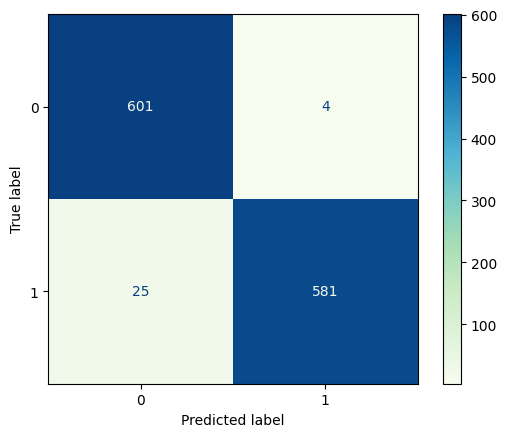

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

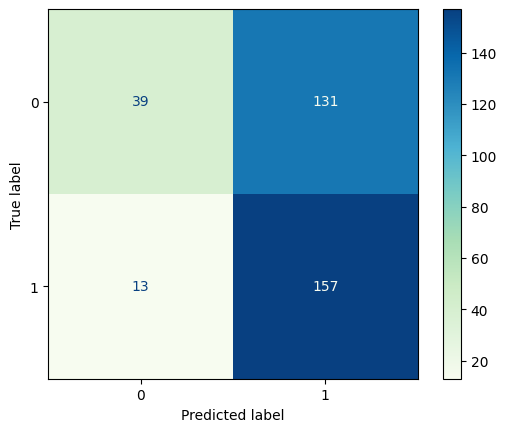

In [26]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(labels_od, predictions_cnn_od, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.9760528488852188
precision: 0.9931623931623932
sensitivity: 0.9587458745874587
specificity: 0.9933884297520661
f1_score: 0.9756507136859781


In [27]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(labels_od, predictions_cnn_od)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(labels_od, predictions_cnn_od)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(labels_od, predictions_cnn_od)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(labels_od, predictions_cnn_od, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.5764705882352941
precision: 0.5451388888888888
sensitivity: 0.9235294117647059
specificity: 0.22941176470588234
f1_score: 0.685589519650655


In [ ]:
# save model
# cnn_model.save("../Snakes-or-No-Snakes/cnn_looAPTR4_seed1_3e")

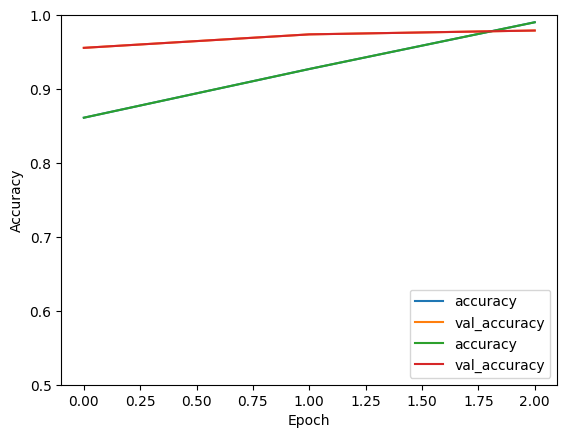

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = cnn_model.evaluate(x_test,  y_test, verbose=2)

## Logistic Regression


In [28]:
# log generators
train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log = True)

In [38]:
def build_log():

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(60, 100, 1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  # compile model with desired features
  model.compile(
    optimizer = "adam", loss = "binary_crossentropy",
    metrics=['accuracy']
  )

  return model

In [39]:
# build the model
log_model = build_log()

In [40]:
# see model structure
log_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 1)                 6001      
                                                                 
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_fit = log_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
 91/201 [============>.................] - ETA: 24:07 - loss: 36.0459 - accuracy: 0.5556

In [29]:
# can load saved (see google sheet for model descriptions)
# log_model = tf.keras.models.load_model("../Snakes-or-No-Snakes/log_looAPTR4_seed1_3e")

In [34]:
log_predict = log_model.predict(
    test_generator,
)

38/38 [==============================] - 504s 14s/step


In [35]:
# get class predictions
predictions_log = log_predict > 0.5
predictions_log = predictions_log.reshape(x_test.shape[0])
print(predictions_log.shape)

(1211,)


In [31]:
test_generator_od = data_generator(filenames_od, labels_od, batch_size = batch_size, log = True)

model_predict_od = log_model.predict(
    test_generator_od,
)

# get class predictions
predictions_log_od = model_predict_od > 0.5
predictions_log_od = predictions_log_od.reshape(filenames_od.shape[0])
print(predictions_log_od.shape)

11/11 [==============================] - 9s 857ms/step
(340,)


In [ ]:
# set(list(predictions_log.reshape(1262)))

{False, True}

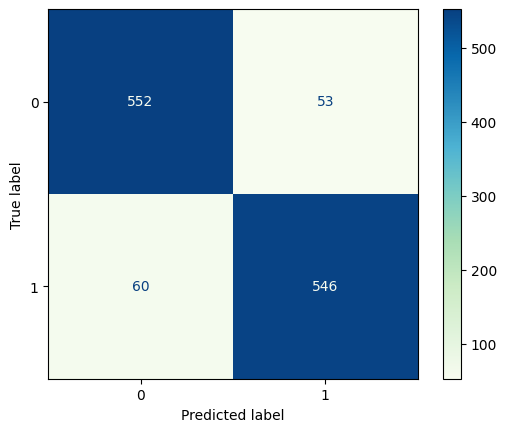

In [36]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_log, cmap = "GnBu")

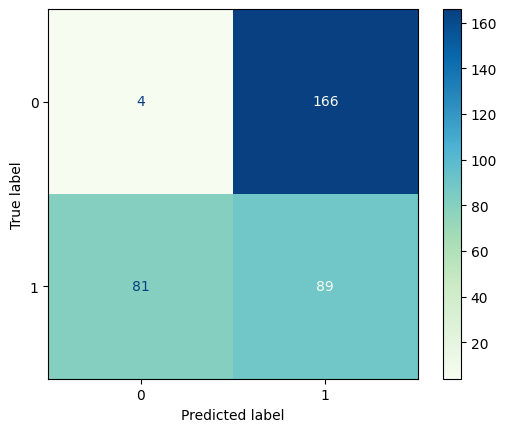

In [32]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(labels_od, predictions_log_od, cmap = "GnBu")

In [37]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_log)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_log)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_log)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_log, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.9066886870355079
precision: 0.9115191986644408
sensitivity: 0.900990099009901
specificity: 0.912396694214876
f1_score: 0.9062240663900415


In [33]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(labels_od, predictions_log_od)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(labels_od, predictions_log_od)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(labels_od, predictions_log_od)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(labels_od, predictions_log_od, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.2735294117647059
precision: 0.34901960784313724
sensitivity: 0.5235294117647059
specificity: 0.023529411764705882
f1_score: 0.4188235294117647


In [ ]:
# save model
log_model.save('../Snakes-or-No-Snakes/log_looAPTR4_seed1_3e')

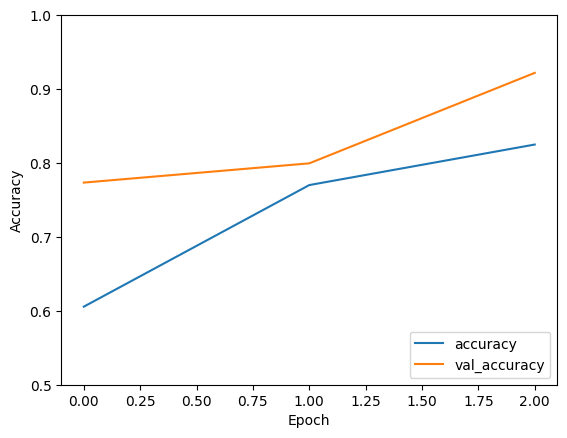

In [ ]:
# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')